In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [3]:
data_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/psf_dataset/'
# wf_psf_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/wf-psf/'
data_comp_dir = '/Users/ec270266/Documents/Phd/Euclid/dev/feature-sed-pred/sed_spectral_classification/output/complementary_exposure/'

# SED folder path
# SED_path = wf_psf_dir+'data/SEDs/save_SEDs/'

# Load the datasets
dataset_gt_train = np.load(data_dir + 'train_12000_stars_id_002_8bins.npy', allow_pickle=True)[()]
print(dataset_gt_train.keys())
dataset_gt_test = np.load(data_comp_dir + 'test_1000_stars_id_003_8bins.npy', allow_pickle=True)[()]

dict_keys(['stars', 'noisy_stars', 'mono_psfs', 'positions', 'SEDs', 'packed_SEDs', 'zernike_coef', 'C_poly', 'parameters', 'SED_ids', 'SNR'])


In [5]:
noisy = True
if noisy == True:
    obs_type = 'noisy_stars'
else:
    obs_type = 'stars'
train_star_offset = 2000

# Compute the star spectral energy distribution estimation
diff_train_gt = []
for i in range(train_star_offset,dataset_gt_train['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_train[obs_type][i])**2) for mono_psf in dataset_gt_train['mono_psfs'][i]]))
    diff_train_gt.append((1-diff)/np.sum(1-diff))
diff_train_gt = np.array(diff_train_gt)
y_train_gt = dataset_gt_train['SED_ids'][train_star_offset:]
print(diff_train_gt.shape)
print(y_train_gt.__len__())

diff_test_gt = []
for i in range(dataset_gt_test['parameters']['n_stars']):
    diff = (np.array([np.sum((mono_psf-dataset_gt_test[obs_type][i])**2) for mono_psf in dataset_gt_test['mono_psfs'][i]]))
    diff_test_gt.append((1-diff)/np.sum(1-diff))
diff_test_gt = np.array(diff_test_gt)
y_test_gt = dataset_gt_test['SED_ids']
print(diff_test_gt.shape)
print(y_test_gt.__len__())

(10000, 8)
10000
(1000, 8)
1000


In [6]:
# # Shuffle train and test datasets
# diff_train_test = np.concatenate((diff_train_gt,diff_test_gt))
# y_train_test = np.concatenate((y_train_gt,y_test_gt))

# randomize = np.arange(len(diff_train_test))
# np.random.shuffle(randomize)
# diff_train_test_rnd = diff_train_test[randomize]
# y_train_test_rnd = np.array(y_train_test)[randomize]

# # Split the dataset into train and test
# diff_train = diff_train_test_rnd[:diff_train_gt.shape[0]]
# y_train = y_train_test_rnd[:diff_train_gt.shape[0]]
# diff_test = diff_train_test_rnd[diff_train_gt.shape[0]:]
# y_test = y_train_test_rnd[diff_train_gt.shape[0]:]

diff_train = diff_train_gt
y_train = y_train_gt
diff_test = diff_test_gt
y_test = y_test_gt

# SVM+PSF Classifier

In [7]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto', probability=True))
clf.fit(diff_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(gamma='auto', probability=True))])

In [8]:
predictions = clf.predict(diff_test)
predictions_proba = clf.predict_proba(diff_test)

prediction confidence: 0.3497441931603091
prediction confidence relaxed: 0.7572221278521376
missed prediction probability: 0.10554031694393942
missed prediction probability relaxed: 0.013589992061260941


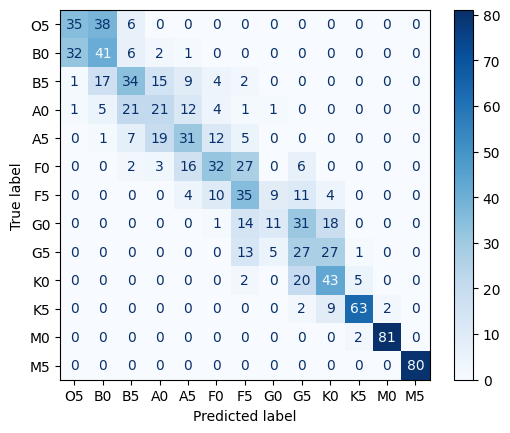

Accuracy:  0.534
Top-2 accuracy:  0.883


In [9]:
p_tot = 0
p_tot_relaxed = 0
p_miss_tot = 0
p_miss_tot_relaxed = 0

for pred_proba, k in zip(predictions_proba, y_test):
	if np.abs(np.argmax(pred_proba) - k) <= 1:
		if k == 0:
			p_tot_relaxed += pred_proba[k] + pred_proba[k+1]
		elif k == 12:
			p_tot_relaxed += pred_proba[k] + pred_proba[k-1]
		else:
			p_tot_relaxed += pred_proba[k] + pred_proba[k-1] + pred_proba[k+1]
	if k == np.argmax(pred_proba):
		p_tot += pred_proba[k]
	if k != np.argmax(pred_proba):
		p_miss_tot += pred_proba[k]
	if np.abs(np.argmax(pred_proba) - k) >= 2:
		p_miss_tot_relaxed += pred_proba[k]

print('prediction confidence:', p_tot/len(predictions_proba))
print('prediction confidence relaxed:',p_tot_relaxed/len(predictions_proba))

print('missed prediction probability:', p_miss_tot/len(predictions_proba))
print('missed prediction probability relaxed:', p_miss_tot_relaxed/len(predictions_proba))

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']
cm = confusion_matrix(y_test, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=star_class_labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

accuracy = np.trace(cm)/np.sum(cm)
relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

print('Accuracy: ', accuracy)
print('Top-2 accuracy: ', relaxed_accuracy)

# CNN+MLP Classifier

In [12]:
import tensorflow as tf
from tensorflow.keras import layers
import sklearn.metrics as skm
import os
from sklearn.model_selection import train_test_split

In [13]:
def calculate_success_rate(confusion_matrix):
    """ Metric that contemplates success as the true spectral class with a tolerance of one adjacent class
    """
    diagonal = np.trace(confusion_matrix)
    diagonal_neighbors = np.sum(np.diagonal(confusion_matrix, offset=1)) + np.sum(np.diagonal(confusion_matrix, offset=-1))
    total_classified = np.sum(confusion_matrix)
    
    success_rate = (diagonal + diagonal_neighbors) / total_classified
    return success_rate

class TrainingCompletionCallback(tf.keras.callbacks.Callback):
    """ Callback to display training information only at the end of the training of one network
    """
    def on_train_end(self, logs=None):
        epochs = len(self.model.history.history['loss'])
        final_loss = self.model.history.history['loss'][-1]
        final_val_loss = self.model.history.history['val_loss'][-1]
        final_acc = self.model.history.history['categorical_accuracy'][-1]
        final_val_acc = self.model.history.history['val_categorical_accuracy'][-1]

        print("Training completed. Number of epochs:", epochs, ", Final training loss:", final_loss, ", Final validation loss:", final_val_loss)
        print("Final accuracy:", final_acc, "Final validation accuracy:", final_val_acc)

completion_callback = TrainingCompletionCallback()

initializer = tf.keras.initializers.GlorotNormal(seed = 25)

star_class_labels = ['O5','B0','B5','A0','A5','F0','F5','G0','G5','K0','K5','M0','M5']

class CNN_model:
    """Wrapper class to train the network with a PCA dataset and a given architecture."""
    def __init__(self, X_train, Y_train, X_test, Y_test, architecture):
        """Receives the name of the dataset and the already created network and loads the needed variables."""
        
        train_size = len(X_train)

        only_train_stars = False
        if only_train_stars:
            train_stars = np.expand_dims(X_train, axis = 3)
            x_train, self.x_test, y_train, self.y_test = train_test_split(
                train_stars, Y_train, test_size = int(train_size/2.6), shuffle = False
            )
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                x_train, y_train, test_size = int(train_size/2.6/2.6), shuffle = False
            )
        else:
            train_stars = np.expand_dims(X_train, axis = 3)
            self.x_test = np.expand_dims(X_test, axis = 3)
            self.y_test = Y_test
        
            self.x_train, self.x_val, self.y_train, self.y_val = train_test_split(
                train_stars, Y_train,test_size = int(train_size/2.6), shuffle = False
            )

        self.y_train_cat = tf.keras.utils.to_categorical(self.y_train,num_classes = 13)
        self.y_val_cat = tf.keras.utils.to_categorical(self.y_val,num_classes = 13)
        self.y_test_cat = tf.keras.utils.to_categorical(self.y_test,num_classes = 13)
        
        self.learning = []
        self.model = architecture
        
    
    def train_model(self, learning_rate, training_epochs, patience_epochs, reduce_lr=False, batch_size=32):

        self.model.compile(
            loss = 'categorical_crossentropy',
            optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = learning_rate),
            metrics = 'categorical_accuracy'
        )
        callbacks = [completion_callback]
        if patience_epochs>0:
            early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = patience_epochs, restore_best_weights=True)
            callbacks.append(early_stopping)
        if reduce_lr:
            lr_red = tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
            callbacks.append(lr_red)
            
            
        learn = self.model.fit(self.x_train, self.y_train_cat, batch_size=batch_size, epochs= training_epochs, verbose = 0, 
                                        callbacks = callbacks, validation_data=(self.x_val,self.y_val_cat), shuffle=True) 

        self.learning.append(learn)

    def predict_test(self, verbose = True):
        """Makes predictions on the test data."""
        y_test_pred = self.model.predict(self.x_test)
        class_predictions = np.argmax(y_test_pred, axis = 1)

        self.f1_test = skm.f1_score(self.y_test, class_predictions, average = None)
        self.f1_mean_test = np.mean(self.f1_test[:13])
        self.confusion_matrix_test = tf.math.confusion_matrix(self.y_test, class_predictions)
        self.success_rate_test = calculate_success_rate(self.confusion_matrix_test)

        if(verbose):
            print("Prediction results for the test set")
            print('Average F1 score:', self.f1_mean_test)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_test)
            print('\nSuccess rate:', self.success_rate_test)


    def predict_val(self, verbose = True):
        """Makes predictions on the validation data."""
        y_val_pred = self.model.predict(self.x_val)
        class_predictions = np.argmax(y_val_pred, axis = 1)

        self.f1_val = skm.f1_score(self.y_val, class_predictions, average = None)
        self.f1_mean_val = np.mean(self.f1_val[:13])
        self.confusion_matrix_val = skm.confusion_matrix(self.y_val, class_predictions)
        self.success_rate_val = calculate_success_rate(self.confusion_matrix_val)

        if(verbose):
            print("Prediction results for the validation set")
            print('Average F1 score:', self.f1_mean_val)
            print("\nConfusion matrix:")
            print(self.confusion_matrix_val)
            print('\nSuccess rate:', self.success_rate_val)

    def save_model(self, N_model = 1, dir=None, name=None):
        if dir is None:
            self.model.save(f"saved_models/{self.dataset_name}/my_model_{N_model}.h5")
        if name is None:
            self.model.save(dir+f"my_model_{N_model}.h5")
        else:
            self.model.save(dir+name+".h5")

    def load_model(self, N_model = 1):
        self.model = tf.keras.models.load_model(f"saved_models/{self.configuration['config_name']}/{self.dataset_name}/my_model_{N_model}.h5")
        

    def plot_training_evolution(self):
        """Plot the loss function and accuracy evolution."""

        loss_evolution = self.learning[-1].history["loss"]
        val_loss_evolution = self.learning[-1].history["val_loss"]
        acc_evolution = self.learning[-1].history['categorical_accuracy']
        val_acc_evolution = self.learning[-1].history['val_categorical_accuracy']

        plt.figure(figsize = (9,5))
        plt.subplot(121)
        plt.plot(loss_evolution,label = "Train set")
        plt.plot(val_loss_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Loss function value")
        plt.legend()
        plt.title("Loss function evolution")

        plt.subplot(122)
        # plt.plot(acc_evolution)
        plt.plot(acc_evolution,label = "Train set")
        plt.plot(val_acc_evolution,label = "Validation set")
        plt.xlabel("Epochs")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Categorical accuracy evolution")

        print("Training loss:", loss_evolution[-1], ", Validation loss:", val_loss_evolution[-1])
        print("Training accuracy:", acc_evolution[-1], ", Validation accuracy:", val_acc_evolution[-1])

    def plot_cf_matrix(self):
        plt.figure(figsize= (12,10))
        heatmap = plt.imshow(self.confusion_matrix_test[:13,:], cmap='Blues')
        plt.xticks(np.arange(13), star_class_labels)
        plt.yticks(np.arange(13), star_class_labels)
        plt.colorbar(heatmap)
        plt.xlabel("Estimated spectral type")
        plt.ylabel("True spectral type")
        plt.show()

    def plot_metrics(self):
        plt.figure(figsize = (9,5))
        plt.bar(np.arange(13), height = self.f1_test[:13], tick_label = star_class_labels ,label = "F1 score")
        plt.axhline(self.f1_mean_test, color='red', linestyle='--', label = 'F1 score average')
        plt.axhline(self.success_rate_test, color='purple', label = 'Success rate')
        plt.xlabel("Spectral class")
        plt.ylabel("Metric")
        plt.legend()
        plt.show()

In [14]:
train_star_offset = 2000
x_train = dataset_gt_train['noisy_stars'][train_star_offset:]
y_train = dataset_gt_train['SED_ids'][train_star_offset:]
x_test = dataset_gt_test['noisy_stars']
y_test = dataset_gt_test['SED_ids']

Training completed. Number of epochs: 2000 , Final training loss: 1.3256417512893677 , Final validation loss: 1.4085111618041992
Final accuracy: 0.4436139166355133 Final validation accuracy: 0.4074363112449646
32/32 [==============================] - 0s 2ms/step
Prediction results for the test set
Average F1 score: 0.2601404677986708

Confusion matrix:
tf.Tensor(
[[38  8  6  6  8  5  5  1  1  1  0  0  0]
 [32  6  7  9  5  9  8  2  4  0  0  0  0]
 [18  3  6  6 10  4  9  7 11  5  3  0  0]
 [11  4 11  5  9  7  8  3  3  3  2  0  0]
 [11  5  5  7 15  4 10  2  7  7  2  0  0]
 [10  4  5  3 14 14 12  3  8  9  4  0  0]
 [ 6  2  5  3  8  4  7  6 13  9  9  1  0]
 [ 4  3  3  1  2  6 11  9 12  8 14  2  0]
 [ 5  2  1  2  5  7  7 10  8 11 12  3  0]
 [ 1  1  1  2  0  6  6  7 11 13 17  5  0]
 [ 1  1  1  0  2  0  3  5  9 13 27 14  0]
 [ 0  0  1  0  0  1  2  1  3  8 17 47  3]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 80]], shape=(13, 13), dtype=int32)

Success rate: 0.517
Training loss: 1.3256417512893677 , 

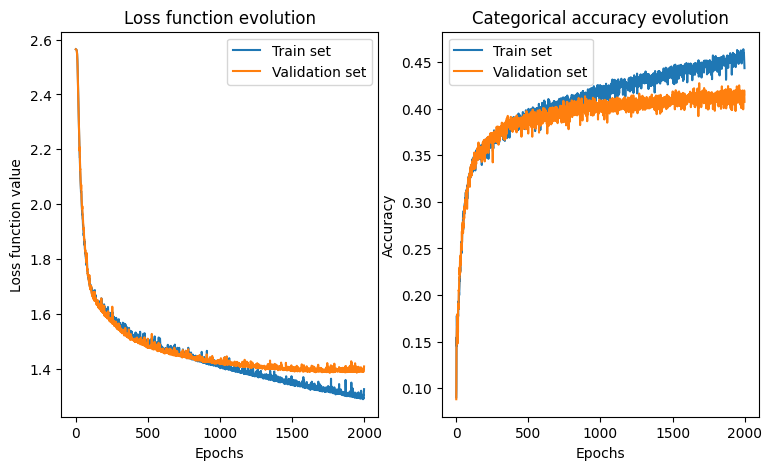

In [23]:
architecture = tf.keras.Sequential([ 
    layers.Cropping2D(cropping=((10, 10), (10, 10)), input_shape = (32,32,1)),
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)), #The original version has average pooling
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)), #The original version has average pooling
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)), #The original version has average pooling
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    # layers.MaxPooling2D((2,2)), #The original version has average pooling
    layers.Conv2D(filters = 32, kernel_size = (3,3), activation = 'relu'),
    layers.Conv2D(filters = 32, kernel_size = (2,2), activation = 'relu'),

    layers.Flatten(),
    # layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    # layers.Dropout(0.3),
    layers.Dense(32, activation = 'relu'),
    # layers.Dropout(0.3),
    layers.Dense(13, activation = 'softmax'),
])

# print architecture
# architecture.summary()

# # Shuffle train and test datasets
# X_train_test = np.concatenate((x_train,x_test))
# Y_train_test = np.concatenate((y_train,y_test))
# randomize = np.arange(len(X_train_test))
# np.random.shuffle(randomize)
# X_train_test_rnd = X_train_test[randomize]
# Y_train_test_rnd = np.array(Y_train_test)[randomize]
# # Split the dataset into train and test
# x_train = X_train_test_rnd[:x_train.shape[0]]
# y_train = Y_train_test_rnd[:x_train.shape[0]]
# x_test = X_train_test_rnd[x_train.shape[0]:]
# y_test = Y_train_test_rnd[x_train.shape[0]:]

# Data Normalization
x_train_norm = (x_train-np.mean(x_train,axis=0))/np.max(np.mean(x_train, axis=0))
x_test_norm = (x_test-np.mean(x_test,axis=0))/np.max(np.mean(x_test, axis=0))

model = CNN_model(x_train_norm, y_train, x_test_norm, y_test, architecture)

model.train_model(training_epochs= 2000, learning_rate= 0.0001, patience_epochs= 0, batch_size=512)

model.predict_test()

model.plot_training_evolution()

Prediction results for the test set


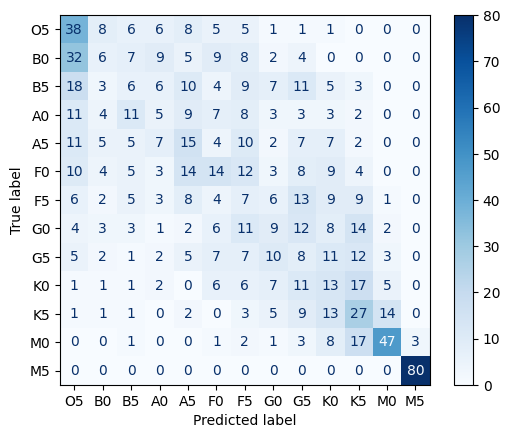

In [24]:
print("Prediction results for the test set")
confusion_matrix_test = model.confusion_matrix_test.numpy()
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_test, display_labels=star_class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

Prediction results for the validation set
121/121 [==============================] - 0s 2ms/step
Prediction results for the validation set
Average F1 score: 0.398488787421511

Confusion matrix:
[[142  73  49  16  16   6   1   0   0   0   0   0   0]
 [156  56  63  27  17   3   4   0   0   0   0   0   0]
 [ 39  24  81  49  59  15  11   0   3   0   0   0   0]
 [ 22  21  66  55  91  27  10   1   4   1   0   0   0]
 [  5   7  34  33 115  26  39  11   5   5   0   0   0]
 [  1   1  10  12  74  54  74  28  23   4   1   0   0]
 [  0   0   3   4  32  52  89  57  53  19   4   0   0]
 [  0   0   1   1   8  16  50  54  78  54  19   0   0]
 [  0   0   0   0   2  12  37  51  92  71  20   1   0]
 [  0   0   1   0   1   8  20  35  85  83  65   4   0]
 [  0   0   0   0   0   0   0   1  13  46 188  50   0]
 [  0   0   0   0   0   0   0   0   0   1  35 253   2]
 [  0   0   0   0   0   0   0   0   0   0   0   0 305]]

Success rate: 0.7639105564222569


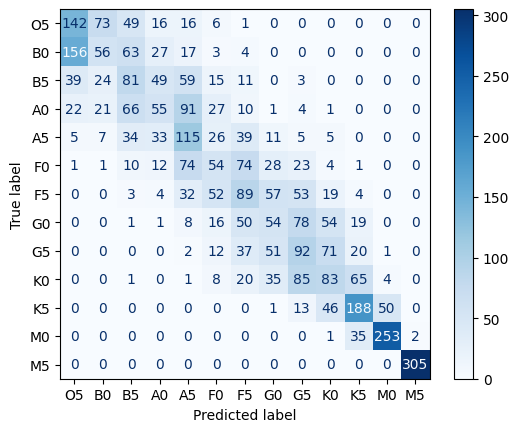

In [25]:
print("Prediction results for the validation set")
model.predict_val()
confusion_matrix_val = model.confusion_matrix_val
# plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix_val, display_labels=star_class_labels)
disp.plot(cmap=plt.cm.Blues)
plt.show()

# Plot the results

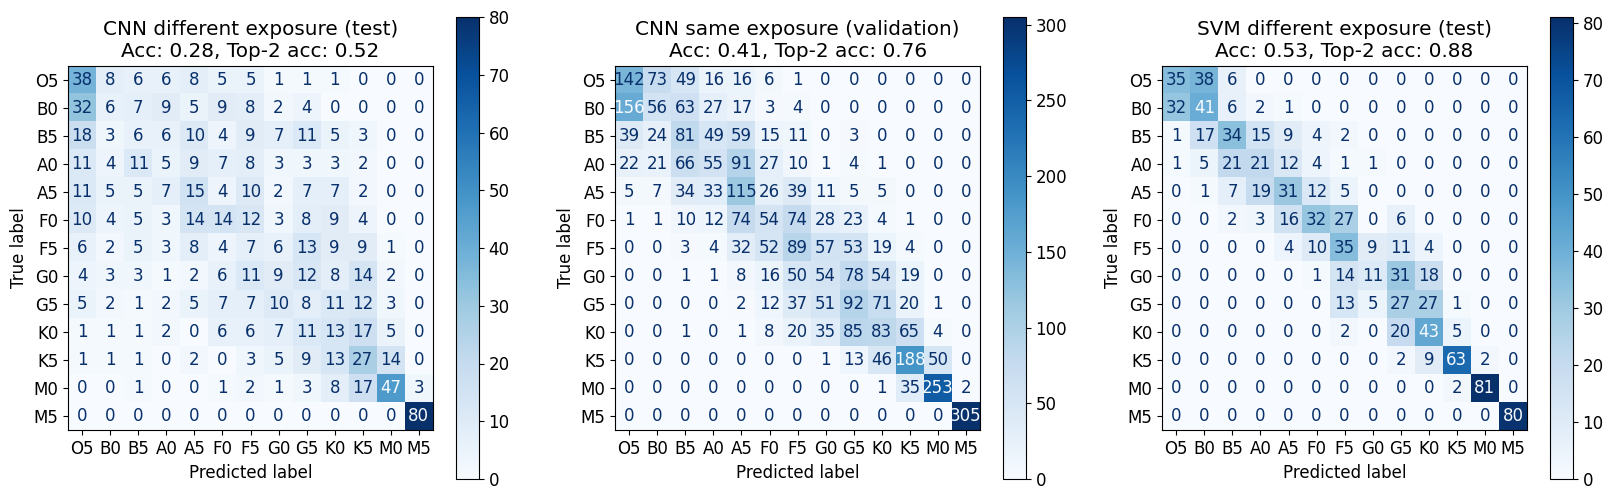

In [58]:
cm_svm = cm
accuracy = np.trace(cm)/np.sum(cm)
relaxed_accuracy = (np.trace(cm, offset=1) + np.trace(cm, offset=-1) + np.trace(cm) )/np.sum(cm)

cm_cnn_test = confusion_matrix_test
accuracy_cnn_test = np.trace(cm_cnn_test)/np.sum(cm_cnn_test)
relaxed_accuracy_cnn_test = (np.trace(cm_cnn_test, offset=1) + np.trace(cm_cnn_test, offset=-1) + np.trace(cm_cnn_test) )/np.sum(cm_cnn_test)

cm_cnn_val = confusion_matrix_val
accuracy_cnn_val = np.trace(cm_cnn_val)/np.sum(cm_cnn_val)
relaxed_accuracy_cnn_val = (np.trace(cm_cnn_val, offset=1) + np.trace(cm_cnn_val, offset=-1) + np.trace(cm_cnn_val) )/np.sum(cm_cnn_val)

plt.figure(figsize=(20,6))

plt.subplot(131)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_test, display_labels=star_class_labels)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('CNN different exposure (test)\nAcc: {:.2f}, Top-2 acc: {:.2f}'.format(accuracy_cnn_test, relaxed_accuracy_cnn_test))

plt.subplot(132)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_cnn_val, display_labels=star_class_labels)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('CNN same exposure (validation)\nAcc: {:.2f}, Top-2 acc: {:.2f}'.format(accuracy_cnn_val, relaxed_accuracy_cnn_val))

plt.subplot(133)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_svm, display_labels=star_class_labels)
disp.plot(cmap=plt.cm.Blues, ax=plt.gca())
plt.title('SVM different exposure (test)\nAcc: {:.2f}, Top-2 acc: {:.2f}'.format(accuracy, relaxed_accuracy))

plt.savefig('../figures/complementary_exposure_cm.pdf')
